In [1]:
# our commonly used functions
from global_bug_bot_functions import  *


# libraries for building convolutional neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.applications import MobileNetV2, DenseNet201
from tensorflow.keras.models import Model

# libraries for tuning models
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperParameters
from tensorflow.keras import backend as K
from keras.callbacks import History, EarlyStopping
from tensorflow.keras.regularizers import l2


# utility libraries
import os
import time
import itertools
import random
import numpy as np



# Set random seeds for reproducibility
seed_value = 2025
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# data set constants
TRAIN_GENERATOR = load_data(TRAIN_DIR)
VAL_GENERATOR = load_data(VALID_DIR)
TEST_GENERATOR = load_data(TEST_DIR, shuffle_flag=False)
EVAL_VAL_GENERATOR = load_data(VALID_DIR, shuffle_flag=False)

# best hps found from tuning
# from ep20_pat3_del0.001_ex1_maxtr20_from_tuning_script_final_tuned_models_results_DenseNet201.csv
# ---> tuned with max epoch = 20, patience = 3, minimum delta = 0.001, max trials = 20
best_lr = 0.001
best_dropout = 0.3
best_batch_size	= 16
best_epochs	= 15


base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# reference:https://www.researchgate.net/figure/DenseNet-201-model-optimization-where-the-number-of-hidden-layers-are-512-128-64-32_fig3_355048995 
# replicating diagram from link, implementing hidden layers that are 512, 128, 64, 32, and ReLU function 
x = Dense(512)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

x = Dense(64)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

x = Dense(32)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

output_layer = Dense(TRAIN_GENERATOR.num_classes, activation='softmax', 
                    kernel_regularizer=l2(0.05))(x)
model = Model(inputs=base_model.input, outputs=output_layer)

optimizer = Adam(learning_rate=best_lr)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# JUST ADDED: get init accuracy before training
initial_loss_val, initial_accuracy_val = model.evaluate(VAL_GENERATOR)
initial_loss_train, initial_accuracy_train = model.evaluate(TRAIN_GENERATOR)

print("Metrics Before Training:")
print(f" - Training   -> Loss: {initial_loss_train:.4f}, Accuracy: {initial_accuracy_train:.4f}")
print(f" - Validation -> Loss: {initial_loss_val:.4f}, Accuracy: {initial_accuracy_val:.4f}")

history = model.fit(TRAIN_GENERATOR,validation_data=VAL_GENERATOR, epochs = best_epochs, batch_size = best_batch_size)

# append intial values for plotting
history.history['accuracy'].insert(0, initial_accuracy_train) #training
history.history['loss'].insert(0, initial_loss_train)  # training

history.history['val_accuracy'].insert(0, initial_accuracy_val)  # validation
history.history['val_loss'].insert(0, initial_loss_val)  # validation

/Users/shirleyfong/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Found 6102 images belonging to 11 classes.
Found 440 images belonging to 11 classes.
Found 220 images belonging to 11 classes.
Found 440 images belonging to 11 classes.


/Users/shirleyfong/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 757ms/step - accuracy: 0.1000 - loss: 3.1728
191/191 ━━━━━━━━━━━━━━━━━━━━ 154s 804ms/step - accuracy: 0.1218 - loss: 3.1737
Metrics Before Training:
 - Training   -> Loss: 3.1679, Accuracy: 0.1234
 - Validation -> Loss: 3.1588, Accuracy: 0.1136
Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 171s 857ms/step - accuracy: 0.6043 - loss: 2.0337 - val_accuracy: 0.7227 - val_loss: 1.4982
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 167s 874ms/step - accuracy: 0.9173 - loss: 0.9122 - val_accuracy: 0.7318 - val_loss: 1.2579
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 166s 870ms/step - accuracy: 0.9762 - loss: 0.5939 - val_accuracy: 0.7614 - val_loss: 1.1605
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 166s 872ms/step - accuracy: 0.9873 - loss: 0.4678 - val_accuracy: 0.7750 - val_loss: 1.0753
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 167s 872ms/step - accuracy: 0.9938 - loss: 0.3888 - val_accuracy: 0.7682 - val_loss: 1.0224
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 164s 861ms/step - accura

reference: https://www.researchgate.net/figure/DenseNet-201-model-optimization-where-the-number-of-hidden-layers-are-512-128-64-32_fig3_355048995

14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 958ms/step
Classification Report:


,precision,recall,f1-score,support
adult_rice_weevil,0.711111,0.800000,0.752941,40.000000
american_house_spider,0.941176,0.800000,0.864865,40.000000
bedbug,0.692308,0.675000,0.683544,40.000000
brown_stink_bug,0.857143,0.900000,0.878049,40.000000
carpenter_ant,0.750000,0.675000,0.710526,40.000000
cellar_spider,0.815789,0.775000,0.794872,40.000000
flea,0.622222,0.700000,0.658824,40.000000
house_centipede,0.897436,0.875000,0.886076,40.000000
silverfish,0.767442,0.825000,0.795181,40.000000
subterranean_termite,0.694444,0.625000,0.657895,40.000000


<Figure size 800x600 with 0 Axes>

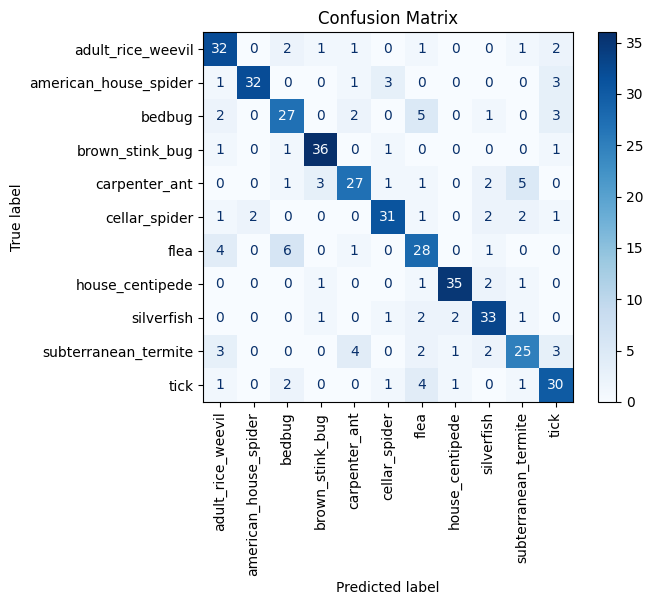

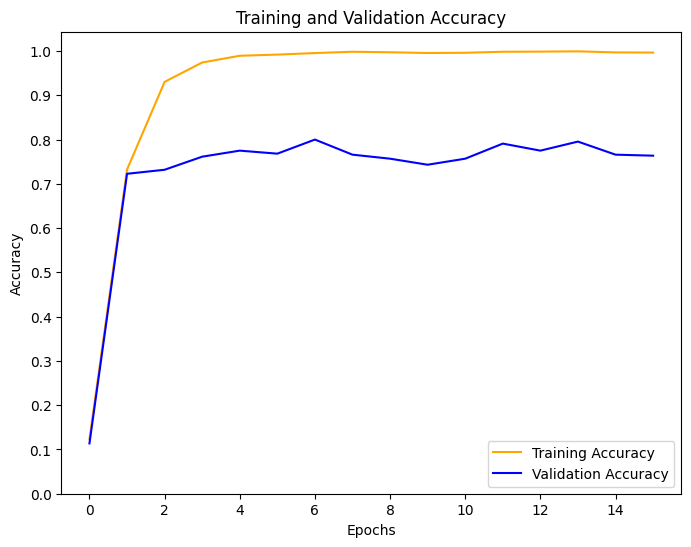

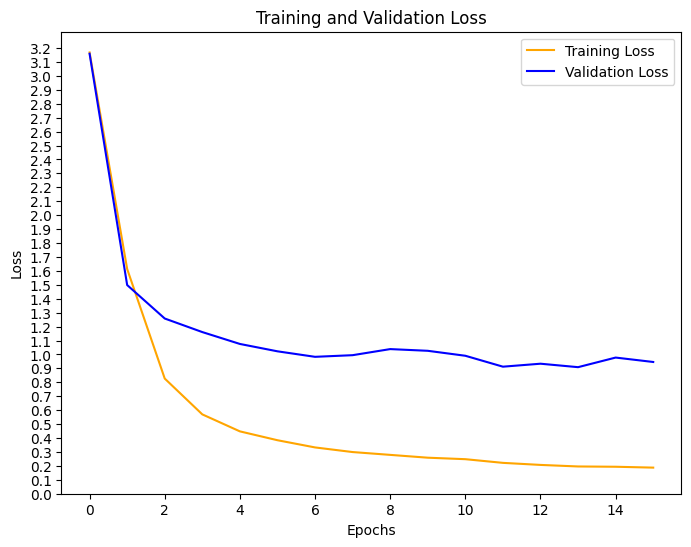

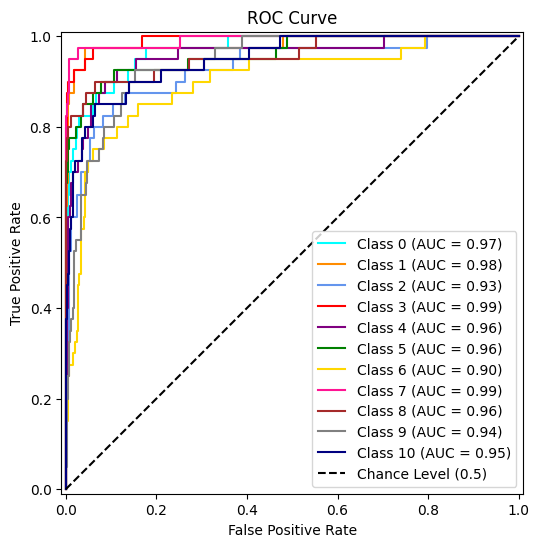

Macro-averaged One-vs-Rest ROC AUC score: 0.96
Accuracy: 0.764
Precision: 0.768
Recall: 0.764
F1 Score: 0.764


{'accuracy': 0.764,
 'precision': 0.768,
 'recall': 0.764,
 'f1_score': 0.764,
 'classification_report_df':                        precision    recall  f1-score     support
 adult_rice_weevil       0.711111  0.800000  0.752941   40.000000
 american_house_spider   0.941176  0.800000  0.864865   40.000000
 bedbug                  0.692308  0.675000  0.683544   40.000000
 brown_stink_bug         0.857143  0.900000  0.878049   40.000000
 carpenter_ant           0.750000  0.675000  0.710526   40.000000
 cellar_spider           0.815789  0.775000  0.794872   40.000000
 flea                    0.622222  0.700000  0.658824   40.000000
 house_centipede         0.897436  0.875000  0.886076   40.000000
 silverfish              0.767442  0.825000  0.795181   40.000000
 subterranean_termite    0.694444  0.625000  0.657895   40.000000
 tick                    0.697674  0.750000  0.722892   40.000000
 accuracy                0.763636  0.763636  0.763636    0.763636
 macro avg               0.767886  

In [2]:
%matplotlib inline
evaluation_metrics(model, EVAL_VAL_GENERATOR, history)

/Users/shirleyfong/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 800ms/step
Classification Report:


,precision,recall,f1-score,support
adult_rice_weevil,0.777778,0.700000,0.736842,20.000000
american_house_spider,0.950000,0.950000,0.950000,20.000000
bedbug,0.650000,0.650000,0.650000,20.000000
brown_stink_bug,0.888889,0.800000,0.842105,20.000000
carpenter_ant,0.833333,0.750000,0.789474,20.000000
cellar_spider,0.894737,0.850000,0.871795,20.000000
flea,0.518519,0.700000,0.595745,20.000000
house_centipede,1.000000,0.800000,0.888889,20.000000
silverfish,0.714286,0.750000,0.731707,20.000000
subterranean_termite,0.545455,0.600000,0.571429,20.000000


<Figure size 800x600 with 0 Axes>

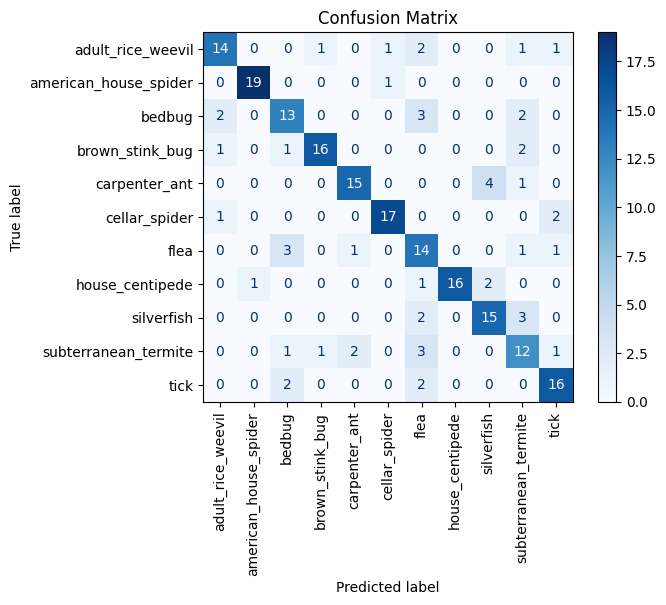

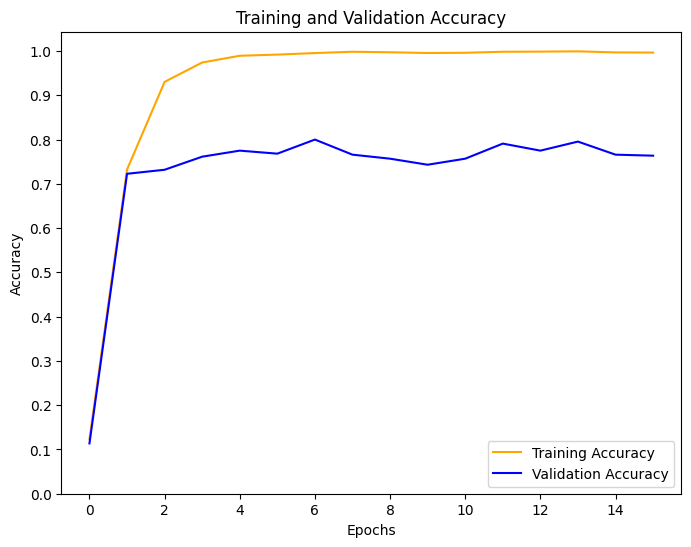

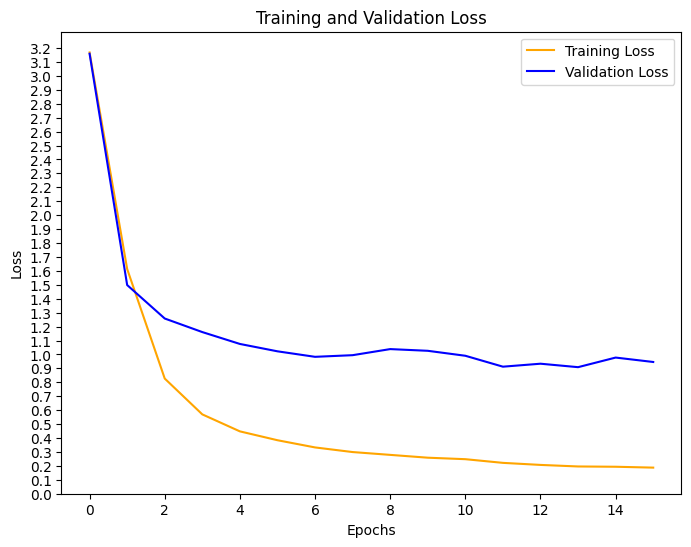

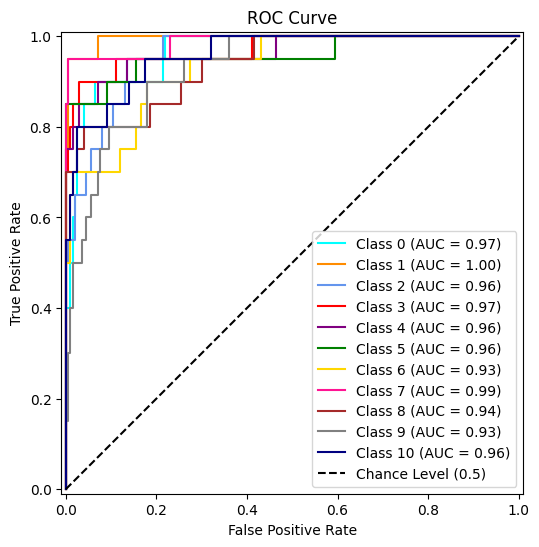

Macro-averaged One-vs-Rest ROC AUC score: 0.96
Accuracy: 0.759
Precision: 0.776
Recall: 0.759
F1 Score: 0.764


{'accuracy': 0.759,
 'precision': 0.776,
 'recall': 0.759,
 'f1_score': 0.764,
 'classification_report_df':                        precision    recall  f1-score     support
 adult_rice_weevil       0.777778  0.700000  0.736842   20.000000
 american_house_spider   0.950000  0.950000  0.950000   20.000000
 bedbug                  0.650000  0.650000  0.650000   20.000000
 brown_stink_bug         0.888889  0.800000  0.842105   20.000000
 carpenter_ant           0.833333  0.750000  0.789474   20.000000
 cellar_spider           0.894737  0.850000  0.871795   20.000000
 flea                    0.518519  0.700000  0.595745   20.000000
 house_centipede         1.000000  0.800000  0.888889   20.000000
 silverfish              0.714286  0.750000  0.731707   20.000000
 subterranean_termite    0.545455  0.600000  0.571429   20.000000
 tick                    0.761905  0.800000  0.780488   20.000000
 accuracy                0.759091  0.759091  0.759091    0.759091
 macro avg               0.775900  

In [3]:
%matplotlib inline
evaluation_metrics(model, TEST_GENERATOR, history)